# XAI 2024 TP5

## PostHoc methods - Tabular data



Author: Arthur Babey

Due: 30.04.2025, 23h59

- Professor: Carlos Peña (<a href="mailto:carlos.pena@heig-vd.ch">carlos.pena@heig-vd.ch</a>)
- Assistant 2024: Arthur Babey (<a href="mailto:arthur.babey@heig-vd.ch">arthur.babey@heig-vd.ch</a>)


Date: Spring 2025

* You will need to fill code and answer questions in this notebook

You have a folder named XAI_TP5_2024 that is structured in the following way:


XAI_TP4_2025_Tabular/

	data/
		winequality-red.csv
        
	model/
		regressor2025.pkl
                
	XAI_TP4_2025_NOM_PRENOM.ipynb

## Instructions

During this TP we will use the (same as TP3) [dataset](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009) which contains various measurements and ratings for the wine quality.

Your tasks will be to complete the code, generate plots, and answer questions related to the following goals:

Goal :

0. Explore : explore and preprocess the dataset 
1. Model : create a regression model and compute metrics 
2. Global explanation : compute global feature importance values and generate plot
3. Local explanation : compute local feature importance to understand the model behaviour at instance level
4. Open the black box : explain a new model using the different methods 
5. Compute Lime : compute lime values from scratch


In [1]:
# import all the libraries
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import lime

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

## 0. Explore and prepare the dataset




- The first step is to read and split our dataset into training and test parts. 

- If necessary (mac or linux) modify the path of your original dataset.




In [2]:
# PATHs and seed for reproducibility

dataset_path = os.path.join("data", "winequality-red.csv")
SEED = 2023

In [3]:
#load the data inot a pandas dataframe

df = pd.read_csv(dataset_path)
column_names = list(df.columns)
print(df["quality"].unique())
# substract quality by three to reduce the labels size 
df["quality"] = df["quality"]-3

df.head()

[5 6 7 4 8 3]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2


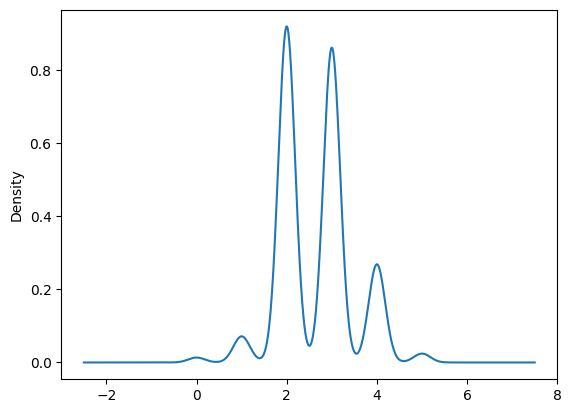

In [4]:
# we can have a look at the label distribution
df['quality'].plot(kind='density')

# display the plot
plt.show()

In [5]:
# split the dataset into a train and a test set 
# the quality feature will be our label vector (y)

X = df.drop("quality", axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## 1. Modeling with a standard ML method 

In the code below you have an implementation of a machine learning model, you will need to : 

1. Train a model and make a prediction with it
2. Compute metrics to evaluate your model


### Regression or Classification with a Decision Tree

Since the output variables are ordered (with 0 being low quality and 5 being high quality), we can perform regression using the DecisionTreeRegressor from the scikit-learn API. : [regressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html).

### Complete the code below to : 

1. Create a model using DecisionTree (use random_state = SEED) for reproducibility
2. Train it with the training data 
3. Make prediction on the test set
4. Compute, print and interpret the (root) mean squared error 

In [6]:
# YOUR CODE 
# name your model "regressor"
regressor = DecisionTreeRegressor(random_state=SEED)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [7]:
# YOUR CODE 
# print the metrics here
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Squared Error (MSE): 0.7937
Root Mean Squared Error (RMSE): 0.8909


These scores are decent, on average our model is off by less than 1 quality point

---
*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /4 </b>
</div>

Commentaires: 

## 2. Global explanation : Feature Importance exploration

Now that we have a model we can try to understand how it is working

In the code below, you will need to : 

1. Compute Feature Importance using : 
    - Built in feature importance method
    - Other Post-Hoc methods
2. Plot you result 
3. Compare your result

### 2.1 Built in Feature Importance exploration :


Here's an example of how to compute feature importance using built-in methods. Many machine learning models have a built-in method to compute feature importance, such as tree models, SVMs, XGBoost, etc. However, this method is limited and often non-consistent.


In [8]:
# If you failed to train a regressor model, you can continue the lab by loading this one by running this cell.

from joblib import load

# Load the regressor model from the specified path
regressor2 = load('model/regressor2025.pkl')

print("Regressor2 model loaded successfully.")

Regressor2 model loaded successfully.


In [9]:
# Get the feature importances
re_importances = regressor.feature_importances_

# The higher values means the more important is the feature. The importance of a feature is computed as the
# Total reduction of the criterion brought by that feature known as Gini importance


# Print the feature importances
for i, feature in enumerate(X.columns):
    print(f"Regressor importance - {feature:<20}: {re_importances[i]:.2f}")

# check that the sum of importance = 1
print(f"Regressor's importances sum is = {re_importances.sum()}")

Regressor importance - fixed acidity       : 0.05
Regressor importance - volatile acidity    : 0.13
Regressor importance - citric acid         : 0.04
Regressor importance - residual sugar      : 0.05
Regressor importance - chlorides           : 0.06
Regressor importance - free sulfur dioxide : 0.05
Regressor importance - total sulfur dioxide: 0.10
Regressor importance - density             : 0.06
Regressor importance - pH                  : 0.04
Regressor importance - sulphates           : 0.12
Regressor importance - alcohol             : 0.29
Regressor's importances sum is = 1.0


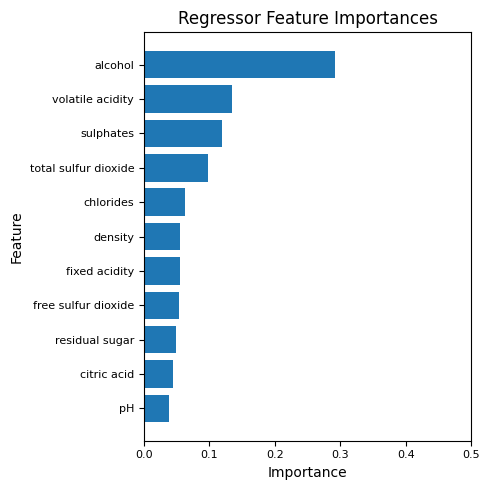

In [10]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the second set of data
sorted_idx = re_importances.argsort()[::-1]
sorted_importances = re_importances[sorted_idx][::-1]
sorted_features = X.columns[sorted_idx][::-1]

ax.barh(sorted_features, sorted_importances)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Regressor Feature Importances')
ax.yaxis.set_ticks(sorted_features)
ax.tick_params(axis='x', labelsize=8)
ax.set_yticklabels(sorted_features, fontsize=8)
ax.set_xlim([0, 0.5])

# Adjust the layout of the subplot
fig.tight_layout()

# Show the plot
plt.show()

---
#### Note :

- Ok so this is interesting but : we can do **better**. We do not have local explanation, we can not see the **heterogeneity** in the population nor the **interactions** between features

- We need to use XAI methods to have a better understanding at what's going on

---

### 2.2 Explaining Feature Importances with Post-Hoc Methods

- To gain deeper insights into both global and local feature importances, we will use **post-hoc** methods. These techniques are designed to explain the behavior of complex models and how they make predictions.

- We will specifically use two post-hoc methods: **LIME** and **SHAP**, both of which are **model-agnostic**—meaning they can provide explanations for any type of model.

- Complete the code below to compute and print the **global SHAP values** on the **test set**:

In [11]:
# create explainer object on our regressor model
explainer_re = shap.TreeExplainer(regressor, feature_names=X_test.columns.tolist())

explainer_re

In [12]:
# compute shap values on the scaled test set
shap_values = explainer_re.shap_values(X_test)

# we can have a look at the shap values for each instance in the test set
pd.DataFrame(shap_values, columns=X_test.columns.tolist()).head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.005358,0.073968,-0.041368,-0.022200,0.036315,0.018104,0.058612,0.034717,-0.018810,-0.493047,-0.276586
1,-0.064718,-0.226143,0.035708,-0.022729,-0.032612,0.201791,-0.079290,0.005332,0.022034,0.059504,-0.534532
2,0.069690,0.196711,-0.012869,0.009388,0.239121,-0.022129,0.216230,0.067962,0.014235,0.516745,0.069263
3,-0.016533,0.010238,-0.016180,-0.042915,0.066576,0.034865,0.003688,0.018274,-0.021144,0.230372,0.097104
4,-0.001598,-0.005990,-0.016981,-0.011906,0.009381,0.128228,0.034863,-0.010505,-0.044453,0.163426,0.119880


### Complete the code below : 

Now make a **bar plot** first and then a **beeswarm plot** of the shap values using the [shap plot API](https://shap.readthedocs.io/en/latest/api_examples.html#explainers) 



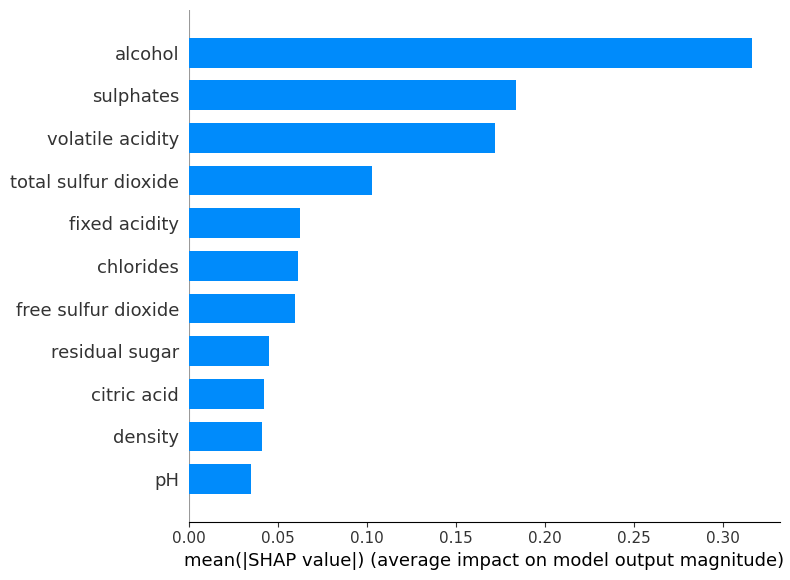

In [13]:
# YOUR CODE
# generate a bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

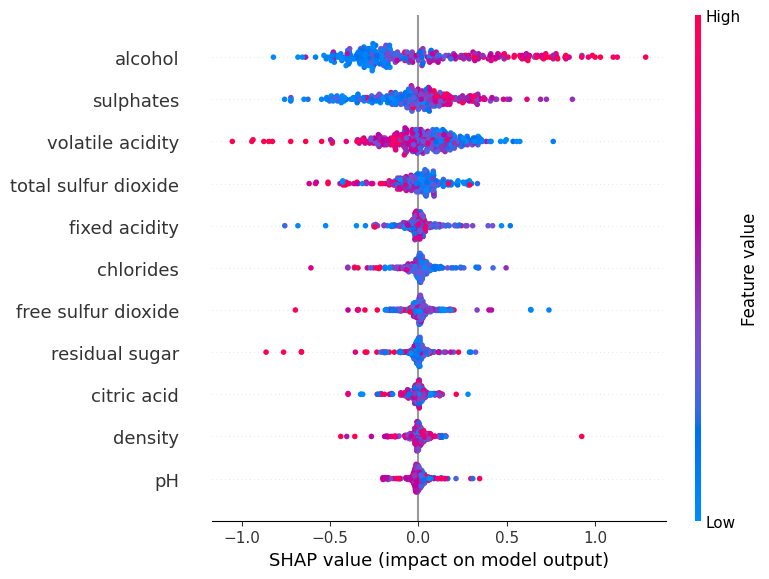

In [14]:
# YOUR CODE
# generate a beeswarm plot
shap.summary_plot(shap_values, X_test)

### Questions : 


How shap values are transformed before the bar plot ?


And the beeswarm plot ?
    
    
What benefits has the beeswarm plot ?     

*Answers:*

**Bar plot:**

The shap values are averaged in the bar plot.

**Beeswarm plot:**

The data in the beeswar mplot ranges from -1.0 to 1.0 and is the impact on the model output.

The beeswarm plot's main benefit is that you can see the distribution of each variable.

---

*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /6 </b>
</div>

Commentaires: 

---

### 2.2.1 SHAP Dependence Plot

SHAP allows us to visualize the **dependence** between a feature's value and its SHAP value using the modern `shap.plots.scatter` function.

This plot helps us understand how a feature contributes to the model’s output across the dataset, and we can optionally color the points by another feature to explore **interactions**.

> Choose a feature to explain (e.g., `"alcohol"`), and use `shap.plots.scatter` to plot its SHAP values.  
> 
>Try adding a `color` argument with another feature (e.g., `"sulphates"`) to explore interactions


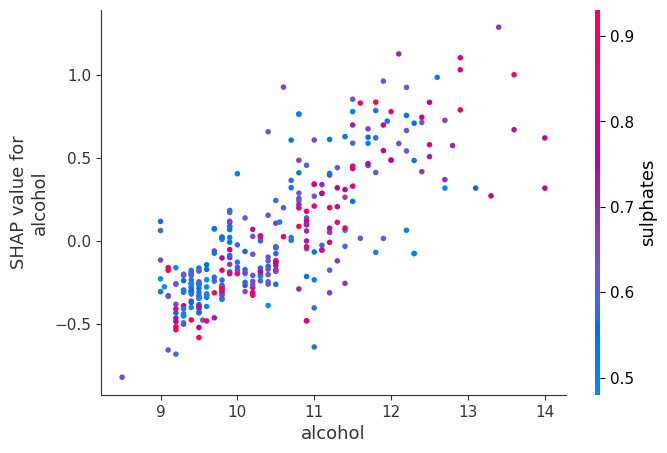

In [15]:
# YOUR CODE 
# make dependence plot
shap.dependence_plot("alcohol", shap_values, X_test, interaction_index="sulphates")

### Questions :

Describe your plot and indicate what can we get from these plots ?  


What can we get from the color axis here ?



*Answers:*

Each dot is a prediction from the dataset. The x-axis is the value of the feature (alcohol). The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction.

The color corresponds to a second feature (sulphates) that may have an interaction effect with the feature we are plotting. If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring. That is not the case for our plot.

---

*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /4 </b>
</div>

Commentaires: 

---
## 3 Local explanation 

### Local explanation with SHAP

SHAP can also be used to make **local** explanation i.e compute shap values for one instance 

A model is often use to make prediction on new instance thus it is important to be able to explain it 

### Complete the code 

1. Using regressor compute the SHAP value for the instance define in the next cell

2. Print the prediction and the true label 

3. Use [shap.plot.waterfall](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.waterfall_plot.html) to plot the SHAP values


In [16]:
# recompute shap values (needed to use waterfall plot)
shap_values = explainer_re(X_test)

# we define an instance to investigate
index = 66
X_test.iloc[index]

fixed acidity            7.70000
volatile acidity         0.43000
citric acid              0.25000
residual sugar           2.60000
chlorides                0.07300
free sulfur dioxide     29.00000
total sulfur dioxide    63.00000
density                  0.99615
pH                       3.37000
sulphates                0.58000
alcohol                 10.50000
Name: 225, dtype: float64

In [17]:
# YOUR CODE 
# print the prediction by *regressor* and the true label for instance index=66
pred = regressor.predict(X_test.iloc[[index]])[0]
true_label = y_test.iloc[index]
print(f"Prediction: {pred:.0f}\nTrue label: {true_label}")

Prediction: 3
True label: 3


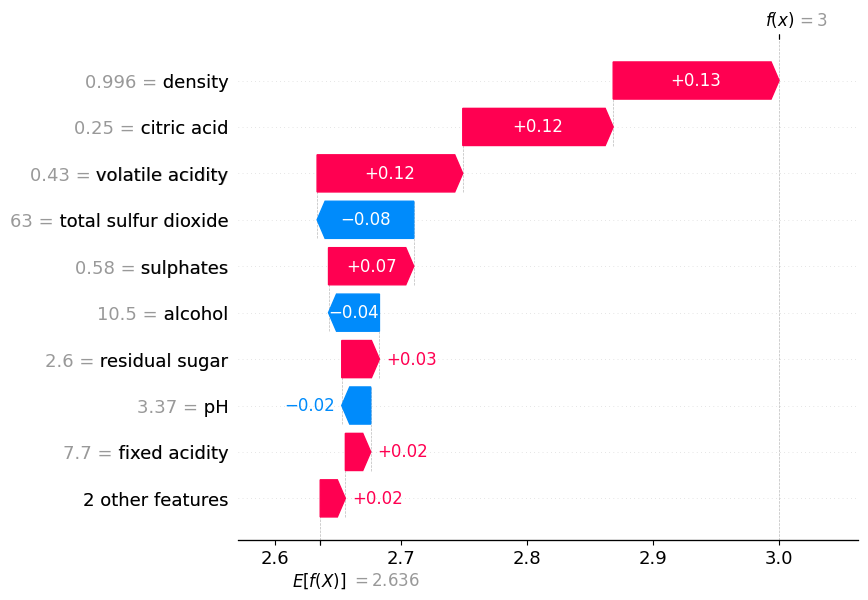

In [18]:
# YOUR CODE
# make a waterfall plot of the prediction index = 66
shap.waterfall_plot(shap_values[index])

### Question :

Describe what the waterfall plot is showing ? 


What does mean the label on the x-axis : E[f(x)] ?



*Answers:*

The waterfall plot is showing each variable's contribution to the prediction

The label on the x-axis is the expectation of f(x)

---

*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /4 </b>
</div>

Commentaires: 

### 3.2 Local explanation with LIME 

[Lime](https://github.com/marcotcr/lime) is another widely used method to compute local explanation. It works completely differently than SHAP but we can also use it to compute local importance per features.  

#### Complete the code : 

1. Use Lime  (the lime.lime_tabular.LimeTabularExplainer module) to create a lime explainer using the training data
2. Use lime explainer.explain_instance to make a plot for instance index=66
 


In [19]:
# YOUR CODE 
# create a lime explainer using the training data
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(training_data=X_train.values, training_labels=y_train, feature_names=X_train.columns.tolist(),
    class_names=['quality'],
    mode='regression')

In [20]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

exp = explainer.explain_instance(
    data_row=X_test.iloc[index], 
    predict_fn=regressor.predict,
    
)

In [21]:
# Code required because of python 3.13
from IPython.display import display, HTML
display(HTML(exp.as_html()))

### Questions : 

Compare your Lime and SHAP result : 

*Answer:*

Both methods predict the same value (3.0), but they way that they explain how they found the result is very different. The features with negative and positive impact to the prediction aren't the same either.

---

### Questions : 


Conceptually what are the differences you might found between global and local prediction ? 


Imagine you are doctor and you are using a model to classify general health based on some measurements, you now have to explain to your patient the outcome of your model : conceptually how could you use global prediction to explain your patient ? and how could you use local prediction ? 


*Answers:*



---

*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /6 </b>
</div>

Commentaires: 

## 4. Open the black box 

Now that we have mutliple tools to understand a model's prediction we will focus on new instance and try to really understand what is going on by opening the black box 



### 4.1 Explain prediction on a new vine : 

Here we define a new vine called *new_vine* by adding noise to the mean of our test sample. Then I set the alcohol value to 16. This is a **very** high and unusual value for a vine thus this should have an clear impact on the prediction. 

In [ ]:
# let's create a new vine data by adding noise to the training data mean
np.random.seed(1)

new_vine = X_test.mean(axis=0) 
gap = np.array(X_test.mean(axis=0)) 
noise = np.random.uniform(low=-gap*0.5, high=gap*0.5, size=gap.shape)

# we set the alcohol value to 16 (very strong vine)

new_vine = new_vine + noise
new_vine['alcohol'] = 16
new_vine

### Question : 

Imagine you are a wine seller looking for new products to sell. To help you, you use your regressor model to predict how good a wine is. One day, a wine producer shows you their new wine (which we'll call "new_vine"). You have all the necessary data, you can use your model and XAI knowledge to decide whether or not to purchase the new wine.

Using your regressor model and your XAI knowledge, decide whether or not to buy the new wine.

In [ ]:
# YOUR CODE 
# Use regressor to make a prediction (here as new_vine is a new example we do not have the true label)

Good news ? 

In [ ]:
# we can compute the shap value for this new vine

new_vine_shap_values = explainer_re(np.array([new_vine]))

### Complete the code below : 

Complete the code below to understand how each features contributed to the prediction :

*hint : a plot we used before could help you*


In [ ]:
# YOUR CODE

### Questions : 

Comment the 5 quality predicted  by the model regarding the feature contribution : 

How the alcohol value impacted the model ? 

Can we have fully confidence in our black box model ? comment

Use your expert knowledge (here you know that 16 alcohol degree is unusual and probably weird) to choose wether or not to buy the **new_vine**. Comment and explain your decision.



*Answers:*

---

*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /8 </b>
</div>

Commentaires: 

### 4.2 Understanding Good and Bad Model Predictions

#### Question:

In the next cell, I provide two instances from the test set: `good_instance`, which is correctly predicted by the model, and `bad_instance`, which is poorly predicted.

Explain the differences between these two instances. Why does the model perform well on `good_instance` while misclassifying `bad_instance`? You may use any methods you want, compute values, create plots, etc, to illustrate your explanation. Provide a detailed discussion on why the model performs well on one instance and poorly on the other.

To ensure that the predictions match the expectations, you can use `regressor2` here.

In [ ]:
good_instance1 = X_test.iloc[15] #label = 4
good_instance2 = X_test.iloc[129] #label = 1

bad_instance1 = X_test.iloc[85] # label = 1 pred = 4
bad_instance2 = X_test.iloc[111] # label = 4 pred = 1

for idx in [15, 129, 85, 111]:

    print(f"The true label is {y_test.iloc[idx]} and the regressor prediction is \
    {regressor.predict((np.array(X_test.iloc[idx])).reshape(1,-1))[0] }")


In [ ]:
# YOUR CODE 

In [ ]:
# YOUR COMMENT/ANSWER

---
*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /6 </b>
</div>

Commentaires: 

---
**Note on Interpretability vs. Causality**

SHAP values and LIME like many other post-hoc explainability methods such as permutation importance, and feature importance in tree-based models — explain how a **model** uses input features to make **predictions**. 

They do not tell us how these features truly cause the target variable in the real world. This is a general limitation of model interpretation: even if a model is highly accurate, it might rely on spurious patterns, correlations, or proxy variables that do not reflect actual causal relationships. Therefore, explanations from a Post-Hoc method should be used to understand **model behavior**, not to infer causal mechanisms.



---
*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /2 </b>
</div>

Commentaires: 

## 5. Impementing Lime step by step 


In this section we will try to compute the lime values by ourselves instead of using the library. We will use the same but simpler dataset. We threshold the quality at six to have a binary classification task (either 0 or 1) and we will use only two features. This will help us to explain and visualize the result

Lime values can be computed in 5 steps :

1. Choosing an instance
2. Make perturbations around the instance
3. Making predictions on the perturbed data
4. Weighting the perturbations
5. Training a local model 

If you are interested you can have a look at the [Lime paper here](https://arxiv.org/pdf/1602.04938.pdf)

In [ ]:
# same dataset we change the quality 

df = pd.read_csv(dataset_path)
column_names = list(df.columns)
df['quality'] = df['quality'].apply(lambda x: 0 if x < 6 else 1)
df.head()

In [ ]:
# we can have a look at the label distribution => it is balance
df['quality'].plot(kind='density')

# display the plot
plt.show()

In [ ]:
# we use only alchohol and sulphates as features to simplify 
features = ['alcohol', 'sulphates']
X = StandardScaler().fit_transform(df[features])
y = df['quality'].values

# random split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=SEED)

# create and fit a model here we will use a simple random forest classifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

y_predicted = classifier.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_predicted)

# Let's see how well our model performed
tn, fp, fn, tp = confusion_matrix(y_test,y_predicted).ravel()
recal = tp/(tp+fn)
precision = tp/(tp+fp)

print("accuracy = {acc:0.3f},\nrecall = {recal:0.3f},\nprecision = {precision:0.3f}".format(
        acc=accuracy, recal=recal,precision=precision))

#### Step 1 : choose an instance 

In [ ]:
# you can choose any instance from the test set, Xi will be the instance we will try to explain 

Xi = X_test[298]
Xi

#### Step 2 : make perturbation around the instance 

#### Complete the function below and use it to make perturbation

You need to return X_perturb which are random points around an instance 

In [ ]:
### YOUR CODE HERE
### COMPLETE THE FUNCTION 

def make_perturbations(instance, sigma=0.5, num=750, seed = 2023 ):
    np.random.seed(seed=seed)
    
    
    return
    
X_perturb = 

In [ ]:
#### Step 3 : Making predictions on the perturbed data

In [ ]:
### YOUR CODE HERE

y_perturb = 


#### Step 4 : Weighting the perturbations

Try to understand what the function is doing

The kernel gives a larger weight to perturbations closer by the instance than those further away. The kernel_width sets a scale for locality: decreasing this value will give more importance to perturbations that lie closer by the instance.

In [ ]:
def get_weights(instance, X_perturb, kernel_width):
    distances = np.sum((instance - X_perturb)**2, axis=1)
    weights = np.sqrt(np.exp(-(distances**2)/(kernel_width**2))) #Kernel function
    return weights

weights = get_weights(Xi, X_perturb, kernel_width=0.9)

#### Step 5 : Training a local model

#### Complete the code below : 

Complete the get local coeffs function, you need to fit a (weighted) **linear regression model** on the perturbed and return the coefficient and the intercept of the linear model 

In [ ]:
### YOUR CODE HERE
### complete the function


def get_local_coeffs(X_perturb, y_perturb, weights):
    local_model = 
    
    return coefs, intercept



(a,b), c = get_local_coeffs(X_perturb, y_perturb, weights)

In [ ]:
# PRINT THE COEFFs AND INTERCEPT

print(f"Alcohol coef : a = {a}")
print(f"Sulphate coef : b = {b}")
print(f"Intercept: c = {c}")

### Questions : 

How do you interpret the coefficient for the alcohol and the sulphates ? How did we call them before ? 

Can we use these values to interpret any new instance ? Why ? 

*Answers:*


---

---
*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /7 </b>
</div>

Commentaires: 

#### Visualization :

The next cell should plot the step 2,3 and 4. Make change if needed to visualize the plot

In [ ]:
x1, x2 = X_perturb[y_perturb == 0], X_perturb[y_perturb == 1]
s1, s2 = weights[y_perturb == 0], weights[y_perturb == 1]

fig, axs = plt.subplots(1,3, figsize = (12,4))

axs[0].scatter((X_perturb)[:, 0], (X_perturb)[:, 1], c="#e9a3c9")
axs[0].scatter(Xi[0], Xi[1], c="blue", marker="o", s=40)
axs[0].set_xlabel(features[0])
axs[0].set_ylabel(features[1])
axs[0].set_title("step 2")

axs[1].scatter((x1)[:,0],(x1)[:,1], c="#e9a3c9", alpha=0.9, label='Quality : 0')
axs[1].scatter((x2)[:,0],(x2)[:,1], c="#a1d76a", alpha=0.7, label = 'Quality: 1')
axs[1].scatter(Xi[0],Xi[1],c="blue",marker="o",s=40 )
axs[1].set_xlabel(features[0])
axs[1].set_ylabel(features[1])
axs[1].legend()
axs[1].set_title("step 3")


axs[2].scatter((x1)[:,0],(x1)[:,1], c="#e9a3c9", alpha=0.7, s=50*s1, label='Quality : 0')
axs[2].scatter((x2)[:,0],(x2)[:,1], c="#a1d76a", alpha=0.7, s=50*s2, label = 'Quality: 1')
axs[2].scatter(Xi[0],Xi[1],c="blue",marker="o",s=40 )
axs[2].set_xlabel(features[0])
axs[2].set_ylabel(features[1])
axs[2].legend()
axs[2].set_title("step 4")

plt.show()




#### Good Job ! The last questions are bonus, so answer it if you want to :) 


## Bonus questions : 

What is the local decision boundary of our binary classification task ?

Can you express it mathematically ? 

Can you plot it ? 

*Answers:*

---

---
*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /3 </b>
</div>

Commentaires: 

FIN